# LDA with Gensim

```yaml
Course:    DS 5001 
Module:    08 Lab
Topic:     LDA with Gensim
Author:    R.C. Alvarado
Date:      05 March 2024
```

**Purpose:** Using Gensim to generate topic models.

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read('../../../env.ini')
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'austen-melville'

## Imports

In [3]:
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Get Data

In [4]:
TOKENS = pd.read_csv(f"{output_dir}/{data_prefix}-TOKEN.csv")
OHCO = list(TOKENS.columns[:5])
TOKENS = TOKENS.set_index(OHCO)

# Create Gensum Corpus

We convert our TOKENS table into Gensim data structures.

Gensim uses lists and dictionaries wrapped in objects to provide various kinds of access.

Note that this is a bit of reinventing the wheel and it's not faster than what we've been doing with Pandas.

In [5]:
TOKENS['pos_group'] = TOKENS.pos.str[:2]

In [6]:
CORPUS = TOKENS[TOKENS.pos_group.str.contains('NN|VB') & ~TOKENS.pos.str.contains('NNP')]

In [7]:
DOCS = CORPUS.dropna().groupby(OHCO[:3]).term_str.apply(list)

In [8]:
DOCS

book_id  chap_num  para_num
105      1         1           [was, man, who, amusement, took, book, found, ...
                   2                                                    [elliot]
                   3           [walter, born, married, daughter, county, lady...
                   4           [had, paragraph, stood, printers, hands, had, ...
                   5           [followed, history, rise, ancient, family, ter...
                                                     ...                        
34970    114       18          [yes, dead, plumage, hides, it, carrion, is, w...
                   19          [dark, veins, burst, heres, deluge, wreck, str...
                   20          [oer, ye, know, came, gasping, wall, fingers, ...
                   21                                                    [finis]
                   24                                                      [end]
Name: term_str, Length: 28161, dtype: object

In [9]:
vocab = Dictionary(DOCS.tolist()) 
vocab.filter_extremes(no_below=20, no_above=0.5)
corpus = [vocab.doc2bow(doc) for doc in DOCS.tolist()]

# Generate LDA

Next, we train a model using Gensim's LDA topic modeler.

We set some training parameters.

Regarding these, here are some notes from the Gensim site:

> First of all, the elephant in the room: how many topics do I need? There is
really no easy answer for this, it will depend on both your data and your
application. I have used 10 topics here because I wanted to have a few topics
that I could interpret and "label", and because that turned out to give me
reasonably good results. You might not need to interpret all your topics, so
you could use a large number of topics, for example 100.

> ``chunksize`` controls how many documents are processed at a time in the
training algorithm. Increasing chunksize will speed up training, at least as
long as the chunk of documents easily fit into memory. I've set ``chunksize =
2000``, which is more than the amount of documents, so I process all the
data in one go. Chunksize can however influence the quality of the model, as
discussed in Hoffman and co-authors [2], but the difference was not
substantial in this case.

> ``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

> I suggest the following way to choose iterations and passes. First, enable
logging (as described in many Gensim tutorials), and set ``eval_every = 1``
in ``LdaModel``. When training the model look for a line in the log that
looks something like this::

>```2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations```

> If you set ``passes = 20`` you will see this line 20 times. Make sure that by
the final passes, most of the documents have converged. So you want to choose
both passes and iterations to be high enough for this to happen.

> We set ``alpha = 'auto'`` and ``eta = 'auto'``. Again this is somewhat
technical, but essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.




In [10]:
num_topics = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

We also make an index to word dictionary, since the model wants it.

In [11]:
temp = vocab[0]  # This is only to "load" the dictionary.
id2word = vocab.id2token

In [12]:
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

# Inspect Results

In [13]:
PHI_gs = pd.DataFrame(model.get_topics(), columns=[v[1] for v in vocab.items()])

In [14]:
THETA_gs = pd.DataFrame([(i, t[0], t[1]) 
    for i, d in enumerate(model.get_document_topics(corpus)) 
    for t in d],
    columns=['doc_id', 'topic_id', 'topic_weight'])\
    .set_index(['doc_id','topic_id'])\
    .unstack(fill_value=0)
THETA_gs.index = DOCS.index
THETA_gs.columns = THETA_gs.columns.droplevel(0)

In [15]:
THETA_gs

topic_id                    0         1    2         3         4         5   \
book_id chap_num para_num                                                     
105     1        1         0.0  0.000000  0.0  0.000000  0.000000  0.000000   
                 2         0.0  0.013627  0.0  0.010247  0.000000  0.011098   
                 3         0.0  0.000000  0.0  0.000000  0.000000  0.000000   
                 4         0.0  0.000000  0.0  0.026857  0.000000  0.047998   
                 5         0.0  0.000000  0.0  0.000000  0.000000  0.000000   
...                        ...       ...  ...       ...       ...       ...   
34970   114      18        0.0  0.010720  0.0  0.000000  0.033568  0.000000   
                 19        0.0  0.000000  0.0  0.046505  0.000000  0.026804   
                 20        0.0  0.000000  0.0  0.000000  0.000000  0.000000   
                 21        0.0  0.013627  0.0  0.010247  0.000000  0.011098   
                 24        0.0  0.045961  0.0  0.000000  0.000000  0.010735   

topic_id                         6         7    8         9   ...        30  \
book_id chap_num para_num                                     ...             
105     1        1         0.091578  0.000000  0.0  0.000000  ...  0.063815   
                 2         0.026035  0.000000  0.0  0.010688  ...  0.020290   
                 3         0.043653  0.000000  0.0  0.000000  ...  0.138228   
                 4         0.031782  0.000000  0.0  0.000000  ...  0.012346   
                 5         0.017159  0.000000  0.0  0.000000  ...  0.011190   
...                             ...       ...  ...       ...  ...       ...   
34970   114      18        0.047135  0.000000  0.0  0.000000  ...  0.015962   
                 19        0.035717  0.000000  0.0  0.000000  ...  0.012094   
                 20        0.016519  0.048872  0.0  0.000000  ...  0.012873   
                 21        0.026035  0.000000  0.0  0.010688  ...  0.020290   
                 24        0.025182  0.000000  0.0  0.010338  ...  0.019625   

topic_id                    31        32        33        34        35  \
book_id chap_num para_num                                                
105     1        1         0.0  0.000000  0.000000  0.000000  0.000000   
                 2         0.0  0.011437  0.012456  0.011988  0.017290   
                 3         0.0  0.000000  0.000000  0.000000  0.012596   
                 4         0.0  0.000000  0.000000  0.000000  0.010521   
                 5         0.0  0.024991  0.000000  0.062673  0.000000   
...                        ...       ...       ...       ...       ...   
34970   114      18        0.0  0.000000  0.000000  0.000000  0.013603   
                 19        0.0  0.000000  0.000000  0.000000  0.010306   
                 20        0.0  0.028757  0.000000  0.000000  0.010970   
                 21        0.0  0.011437  0.012456  0.011988  0.017290   
                 24        0.0  0.011062  0.012048  0.011595  0.016724   

topic_id                         36        37        38        39  
book_id chap_num para_num                                          
105     1        1         0.000000  0.020997  0.036653  0.000000  
                 2         0.011052  0.010999  0.011120  0.012664  
                 3         0.000000  0.000000  0.000000  0.000000  
                 4         0.000000  0.027309  0.000000  0.000000  
                 5         0.000000  0.024755  0.024820  0.000000  
...                             ...       ...       ...       ...  
34970   114      18        0.000000  0.000000  0.000000  0.000000  
                 19        0.046988  0.000000  0.047021  0.047944  
                 20        0.000000  0.000000  0.000000  0.000000  
                 21        0.011052  0.010999  0.011120  0.012664  
                 24        0.010690  0.010639  0.010755  0.012249  

[28161 rows x 40 columns]

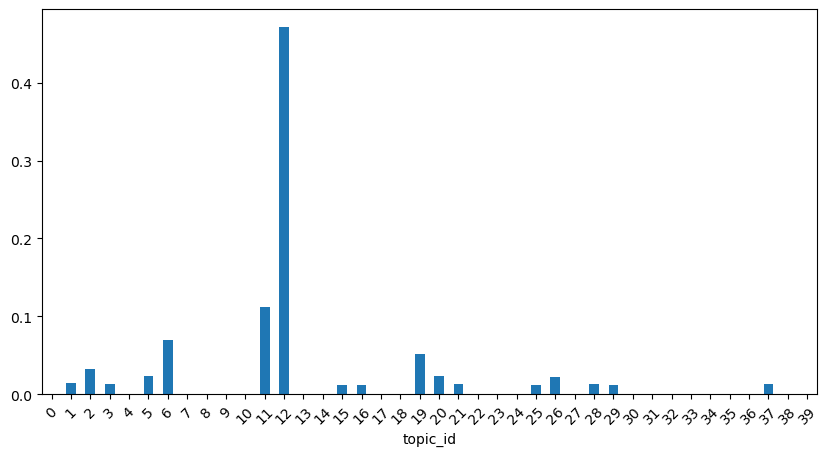

In [16]:
THETA_gs.iloc[7].plot.bar(rot=45, figsize=(10,5));

# Topic Coherence 

Topic coherence measures **the degree of semantic similarity between high-scoring words in the topic**. 
- These measures help in distinguishing between topics that are semantically interpretable and topics that are artifacts of the statistical model.
- A coherent topic will have high-scoring words that are semantically related, indicating that the topic is likely to be meaningful.

UMass topic coherence is based on document co-occurrence frequencies. A high score suggests that the top words in a topic frequently occur together in 
documents.

**QUESTION: Does co-ocurrence imply semantic similarity?**

More info from the docs:

> We can compute the topic coherence of each topic. Below we display the
average topic coherence and print the topics in order of topic coherence.
>
> Note that we use the "Umass" topic coherence measure here (see
`gensim.models.ldamodel.LdaModel.top_topics`), Gensim has recently
obtained an implementation of the "AKSW" topic coherence measure (see
accompanying blog post, http://rare-technologies.com/what-is-topic-coherence/).
>
> If you are familiar with the subject of the articles in this dataset, you can
see that the topics below make a lot of sense. However, they are not without
flaws. We can see that there is substantial overlap between some topics,
others are hard to interpret, and most of them have at least some terms that
seem out of place. If you were able to do better, feel free to share your
methods on the blog at http://rare-technologies.com/lda-training-tips/ !




In [17]:
top_topics = model.top_topics(corpus)

Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.

In [18]:
# top_topics

In [19]:
# pd.DataFrame(top_topics)

In [20]:
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'Average topic coherence: {round(avg_topic_coherence, 3)}.')

Average topic coherence: -9.011.


# Top Topics

In [21]:
TOPICS = pd.DataFrame(
    [(i, j, topic[1], *reversed(term_pair)) for i, topic in enumerate(top_topics) for j, term_pair in enumerate(topic[0])], 
    columns=['topic_id', 'term_rank', 'll', 'term_str', 'term_weight']).set_index(['topic_id','term_rank'])\
    .term_str.unstack().apply(lambda x: ' '.join(x), axis=1).to_frame('top_terms')

In [22]:
TOPICS['coherence'] = pd.DataFrame(top_topics)[1]

In [23]:
TOPICS.sort_values('coherence', ascending=False)

,top_terms,coherence
topic_id,,
0,was had were him been be time did being them m...,-2.172741
1,be have it me do see has say you know am go th...,-2.251506
2,day came room went morning till passed door da...,-3.198236
3,hand eyes thou side head face stood air turned...,-3.603158
4,looking sight house city view ground forth dar...,-4.366380
5,mother love father sister girl woman stranger ...,-4.833586
6,feet fell earth boy back caught instant ran fo...,-5.258807
7,is are this life hate live people makes humani...,-6.818160
8,end in arm chair on away walked quarter step m...,-7.111730
